<a href="https://colab.research.google.com/github/MaorKer/Wiezmann_ML_Course/blob/HW3/Maor_Kereth_Homework_3_point_cloud_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#if youre running on colab, run this line first to properly load the h5 files
!pip install tables --upgrade

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [4]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [ ]:
ds.label.unique().size()

torch.Size([10])

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

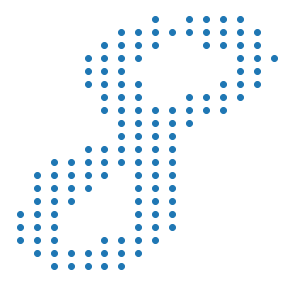

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

In [ ]:
ds.n_points

0       117
1       130
2        88
3        70
4        97
       ... 
9995    120
9996    111
9997    114
9998     81
9999     88
Name: n_points, Length: 10000, dtype: object

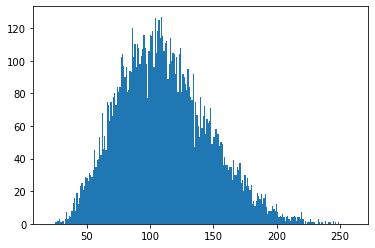

In [ ]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [5]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

In [6]:
# the linear layer operates on the last dimension:

linear_layer = nn.Linear(10,5)

linear_layer(  torch.rand((345,10)) ).shape, linear_layer(  torch.rand((345,76,10)) ).shape

(torch.Size([345, 5]), torch.Size([345, 76, 5]))

In [ ]:
# for the the mean operation you need to specify the dimension:

x = torch.rand((42,15,10))

torch.mean(x,dim=1).shape   

torch.Size([42, 10])

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [20]:
class DeepSet(nn.Module):
    def __init__(self):
        super(DeepSet, self).__init__()
        self.linear_emb=nn.Linear(2,8)  #shape - (n_pictues_inbatch,n.points,8)
        self.linear_emb2=nn.Linear(8,16)  
        self.linear_emb3=nn.Linear(16,32)  
        self.linear_emb4=nn.Linear(32,64)  

        self.linear1=nn.Linear(64,16)
        self.linear2=nn.Linear(16,10)
    
    def forward(self, x):
        x = F.relu(self.linear_emb(x))
        x = F.relu(self.linear_emb2(x))
        x = F.relu(self.linear_emb3(x))
        x = F.relu(self.linear_emb4(x))

        x = torch.mean(x,dim=1)

        x = F.relu(self.linear1(x))
        output = self.linear2(x)
        
        return output 

In [21]:
net = DeepSet()
net.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [39]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        x, y = x.cuda(), y.cpu()

        prediction = net(x)
        prediction = prediction.cpu()
        prediction = prediction.data.numpy()
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
    print (total_correct/float(total_number))   
    return total_correct/float(total_number)

In [23]:
def compute_loss(data_loader,net, loss_func):
    
    net.eval()
    
    total_number = 0
    sizes = []
    losses = []
    
    for x,y in data_loader:
        x, y = x.cpu(), y.cpu()
        logits = net(x)
        loss = loss_func(logits, y)
        sizes.append(x.shape[0])
        losses.append(loss.cpu().item())
        total_number+=x.shape[0]

    mean_loss = 0
    for loss, size in zip(losses, sizes):
        mean_loss += loss * size
    mean_loss /= total_number
    # print(losses)

    # mean_loss = sum([loss * size for loss, size in zip(losses, sizes)]) / total_number
        
    return mean_loss

In [24]:


batch_size = 50
ds_train = CustomDataset('/content/drive/My Drive/ML Weizmann/training_ds.h5')
ds_val = CustomDataset('/content/drive/My Drive/ML Weizmann/valid_ds.h5')

batch_sampler_train = CustomBatchSampler(ds_train.n_points, batch_size)
train_data_loader = DataLoader(ds_train, batch_sampler=batch_sampler_train)

batch_sampler_val = CustomBatchSampler(ds_val.n_points, batch_size)
val_data_loader = DataLoader(ds_val, batch_sampler=batch_sampler_val)



In [42]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
n_epochs=170

for epoch in tqdm(range(160 , n_epochs)):

    net.train()
    for x, y in tqdm(train_data_loader):
        x, y = x.cuda(), y.cuda()
        logits = net(x)
        loss = loss_func(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch > 150 :
    train_accs.append(compute_accuracy(train_data_loader, net))
    val_accs.append(compute_accuracy(val_data_loader, net))
    train_losses.append(compute_loss(train_data_loader, net, loss_func))
    val_losses.append(compute_loss(val_data_loader, net, loss_func))



0.8284
0.8194


In [48]:
for epoch in tqdm(range(160 , 170)):

    net.train()
    for x, y in tqdm(train_data_loader):
        x, y = x.cuda(), y.cuda()
        logits = net(x)
        loss = loss_func(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch > 150 :
      train_accs.append(compute_accuracy(train_data_loader, net))
      val_accs.append(compute_accuracy(val_data_loader, net))
      # train_losses.append(compute_loss(train_data_loader, net, loss_func))
      # val_losses.append(compute_loss(val_data_loader, net, loss_func))


0.7806
0.7672



0.8355
0.8285



0.8316
0.8206



0.8257
0.8167



0.833
0.8202



0.841
0.8263



0.8293
0.8225



0.8163
0.8067



0.8254
0.8169



0.8386
0.8328



In [40]:
train_accs.append(compute_accuracy(train_data_loader, net))
val_accs.append(compute_accuracy(val_data_loader, net))

0.731
0.734


In [44]:
train_accs

[0.8284]

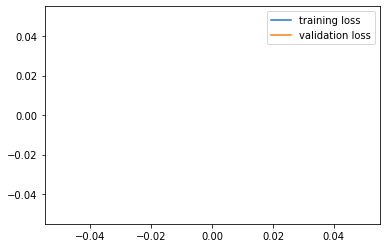

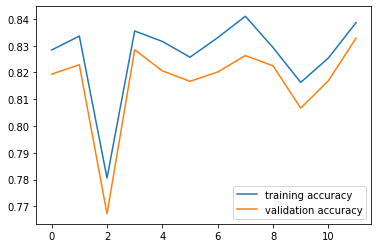

In [49]:
plt.figure()
plt.plot(train_losses,label='training loss')
plt.plot(val_losses,label='validation loss')
plt.legend()
plt.savefig('loss.png')
plt.figure()
plt.plot(train_accs,label='training accuracy')
plt.plot(val_accs,label='validation accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [45]:
torch.save(net.state_dict(), 'model.pt')
